# Team 8 - Analyzing Airbnb dataset

**Business Context:**

Airbnb has successfully disrupted the traditional hospitality industry as more and more travelers decide to use Airbnb as their primary accommodation provider. Since its beginning in 2008, Airbnb has seen an enormous growth, with the number of rentals listed on its website growing exponentially each year.

**Dataset Used**

Source - http://insideairbnb.com/ (Seattle, Washington, United States)
>Last Updated - 14 Jul 2019

>Files Used   
- listings.csv.gz   (43MB) - (8921 x 106)
- calendar.csv.gz (140MB) - (3256165 x 7)                 


**In this project we try to analyze airbnb data for city of seattle and answer below questions:**

1. What are the busiest times of each season to visit Seattle?

2. How do prices vary across neighbourhood?

3. What factors cause variability in prices?

4. What is the predicted price for each listing?

5. Recommendation

Overall, we would try to understand the rental market based on Airbnb's data and predict a price for someone who is entering this segment. 

## Plan of action
1. Acquire and import Airbnb datasets
2. High level overview of data
3. Data Cleaning & Preprocessing
    - Cleaning price values & other columns
    - Handling date conversions and new columns
    - Managing missing data
    - Understanding and removing outliers
    - Feature engineering: Amenities, Property Type & Room Type 
    - Feature engineering: Distance from Downtown
4. Exploratory Data Analysis (Visualizations)
5. Modeling
    - Preparing training and target dataset
    - Prediction using Linear Regression
    - Prediction using Random Forest
    - Normalizing data values
    - Ordinary Least Square Summary
    - Accuracy based on R$^{2}$ and MAE
6. Conclusion 


In [1]:
#Importing necessary libraries and airbnb datasets
import numpy as np
import pandas as pd
import seaborn as sn
import calendar
pd.set_option("max_columns", None)

#loading files
listings = pd.read_csv("./listings_2019.csv",dtype={'monthly_price': str,'weekly_price': str})
cal = pd.read_csv("./calendar_2019.csv")

In [2]:
df = listings.property_type.value_counts(normalize=True)
property_filter = ['Apartment','House','Guest suite','Townhouse','Condominium']

In [3]:
print("Number of nulls in PRICE column:",listings.price.isna().sum())
print("Number of nulls in CLEANING_FEE column:",listings.cleaning_fee.isna().sum())
print("Number of nulls in SECURITY_DEPOSIT column:",listings.security_deposit.isna().sum())

Number of nulls in PRICE column: 0
Number of nulls in CLEANING_FEE column: 807
Number of nulls in SECURITY_DEPOSIT column: 1607


In [5]:
listings.cleaning_fee.fillna('$0.00', inplace=True)
listings.security_deposit.fillna('$0.00', inplace=True)

In [6]:
#To verify all records are replaced with 0
print("Number of nulls in PRICE column:",listings.price.isna().sum())
print("Number of nulls in CLEANING_FEE column:",listings.cleaning_fee.isna().sum())
print("Number of nulls in SECURITY_DEPOSIT column:",listings.security_deposit.isna().sum())

Number of nulls in PRICE column: 0
Number of nulls in CLEANING_FEE column: 0
Number of nulls in SECURITY_DEPOSIT column: 0


In [7]:
#Cleaning Price values
cal['price']=cal['price'].str.replace("$","").str.replace(",","").astype('float')
listings['price']=listings['price'].str.replace("$","").str.replace(",","").astype('float')
listings['extra_people']=listings['extra_people'].str.replace("$","").str.replace(",","").astype('float')
listings['cleaning_fee']=listings['cleaning_fee'].str.replace("$","").str.replace(",","").astype('float')
listings['security_deposit']=listings['security_deposit'].str.replace("$","").str.replace(",","").astype('float')
listings['host_acceptance_rate']=listings['host_acceptance_rate'].replace("%","").replace(",","").astype('float')
listings['host_response_rate']=listings['host_response_rate'].str.replace("%","").str.replace(",","").astype('float')
listings.amenities = listings.amenities.str.replace("{","").str.replace("}","").str.replace('"',"")

In [8]:
#Quick look at how our price data is distributed
print(listings['price'].describe())

count    8921.000000
mean      167.446587
std       190.964441
min         0.000000
25%        80.000000
50%       120.000000
75%       189.000000
max      5400.000000
Name: price, dtype: float64


In [9]:
#To maintain order for month by names
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun","Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
#converting date column to proper date format
cal['date']=pd.to_datetime(cal['date'])
cal['year']=cal['date'].dt.year
cal['month']=cal['date'].dt.month.apply(lambda x: calendar.month_abbr[x])
cal['month'] = pd.Categorical(cal['month'], categories=months, ordered=True) #using months variable here to categorize
cal['day']=cal['date'].dt.day

In [9]:
listings.isna().sum().sort_values(ascending=False)

thumbnail_url             8921
medium_url                8921
host_acceptance_rate      8921
xl_picture_url            8921
square_feet               8565
                          ... 
minimum_nights               0
maximum_nights               0
minimum_minimum_nights       0
maximum_minimum_nights       0
id                           0
Length: 106, dtype: int64

In [10]:
#Removing irrelevant columns and columns with too many NaNs 
listings.drop(columns=['square_feet', 'license','monthly_price','weekly_price','notes','neighborhood_overview'
                      ,'transit','host_about','review_scores_checkin','review_scores_value','review_scores_location'
                      ,'review_scores_cleanliness','review_scores_communication','last_review','first_review','space'
                      ,'thumbnail_url','medium_url','xl_picture_url','host_neighbourhood','summary','host_location'
                      ,'neighbourhood','review_scores_accuracy','zipcode','host_url','scrape_id','name'
                      ,'description','last_scraped','picture_url','host_url','host_id','host_name','host_thumbnail_url'
                      ,'host_picture_url','host_verifications','neighbourhood_cleansed','street','city','state','market'
                      ,'country_code','country','smart_location','is_location_exact','host_response_time','host_since'
                      ,'calendar_updated','xl_picture_url','access','host_acceptance_rate','interaction','house_rules'
                      ,'host_identity_verified','jurisdiction_names','requires_license','availability_60','availability_30'
                      ,'availability_90','availability_365','listing_url','experiences_offered','calendar_last_scraped'],
              inplace=True)

In [11]:
#Since there are very few listings with missing bedrooms and bathroom, we will remove those rows as well
listings.dropna(subset=['bathrooms', 'bedrooms','host_is_superhost','host_has_profile_pic',
                        'host_total_listings_count','property_type','host_listings_count','amenities','beds'], inplace=True)

In [12]:
# listings['host_acceptance_rate'].describe()
# listings['review_scores_rating'].describe()
# listings['reviews_per_month'].describe()
# listings['host_response_rate'].describe()

In [12]:
listings.review_scores_rating.fillna(listings['review_scores_rating'].median(), inplace=True)
listings.reviews_per_month.fillna(listings['reviews_per_month'].median(), inplace=True)
listings.host_response_rate.fillna(listings['host_response_rate'].median(), inplace=True)

In [14]:
#Outlier removal

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e252780>]],
      dtype=object)

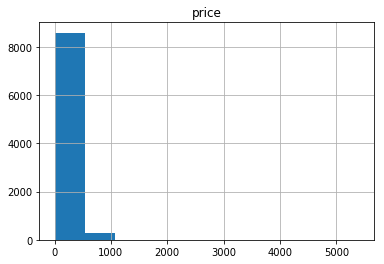

In [13]:
listings[['price']].hist()

In [14]:
fig = plt.figure(figsize=(13,1))
ax = fig.gca()
listings.boxplot(column='price', ax=ax,vert=False)
ax.set_title('BoxPlot of Prices')
ax.set_xlabel('Prices')
ax.set_label('Count')

NameError: name 'plt' is not defined

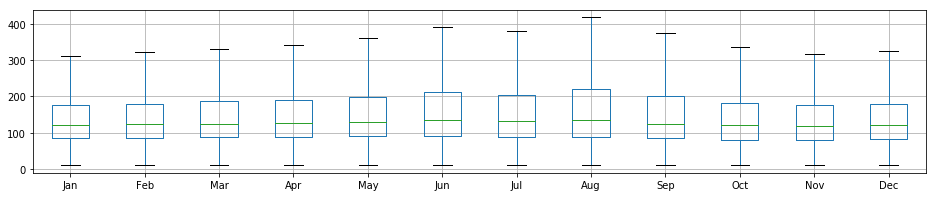

In [20]:
price_month=cal[['month','price']]
price_month_mean=price_month.groupby('month').mean()
price_month1=price_month.pivot(columns='month',values='price')
plt.figure(figsize=(16,3))
plot2=price_month1.boxplot(showfliers=0)

In [21]:
listings.query('price<=600 & price>0', inplace=True)
listings.query('property_type in @property_filter', inplace=True)

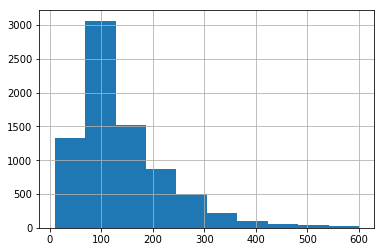

In [22]:
listings['price'].hist()

In [23]:
listings.query('price<=500 & price>0', inplace=True)

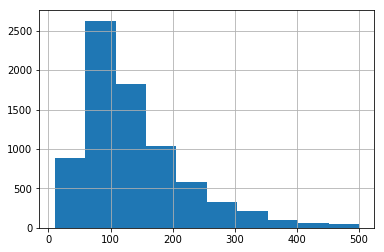

In [24]:
listings['price'].hist()

In [16]:
amenities = listings.amenities.str.split(',').tolist()
amenities

[['Internet',
  'Wifi',
  'Kitchen',
  'Free parking on premises',
  'Pets allowed',
  'Free street parking',
  'Indoor fireplace',
  'Heating',
  'Family/kid friendly',
  'Washer',
  'Dryer',
  'Smoke detector',
  'Carbon monoxide detector',
  'First aid kit',
  'Fire extinguisher',
  'Essentials',
  'Shampoo',
  'Hangers',
  'Hair dryer',
  'Iron',
  'Laptop friendly workspace',
  'High chair',
  'Children’s books and toys',
  'Pack ’n Play/travel crib',
  'Hot water',
  'Luggage dropoff allowed',
  'Long term stays allowed',
  'Host greets you',
  'Lake access'],
 ['TV',
  'Internet',
  'Wifi',
  'Free street parking',
  'Heating',
  'Family/kid friendly',
  'Smoke detector',
  'Carbon monoxide detector',
  'First aid kit',
  'Essentials',
  'Shampoo',
  '24-hour check-in',
  'Hangers',
  'Hair dryer',
  'Iron',
  'translation missing: en.hosting_amenity_49',
  'Self check-in',
  'Lockbox',
  'Private entrance',
  'Hot water',
  'Microwave',
  'Coffee maker',
  'Refrigerator',
  'Si

In [17]:
unqiue_values = np.unique(np.concatenate(amenities))
unqiue_values

array([' toilet', '24-hour check-in', 'Accessible-height bed',
       'Accessible-height toilet', 'Air conditioning', 'Air purifier',
       'Alfresco bathtub', 'Amazon Echo', 'BBQ grill', 'Baby bath',
       'Baby monitor', 'Babysitter recommendations', 'Balcony',
       'Bath towel', 'Bathroom essentials', 'Bathtub',
       'Bathtub with bath chair', 'Beach essentials', 'Beach view',
       'Beachfront', 'Bed linens', 'Bedroom comforts', 'Bidet',
       'Body soap', 'Breakfast', 'Breakfast table', 'Building staff',
       'Buzzer/wireless intercom', 'Cable TV', 'Carbon monoxide detector',
       'Cat(s)', 'Ceiling fan', 'Central air conditioning',
       'Changing table', 'Children’s books and toys',
       'Children’s dinnerware', 'Cleaning before checkout',
       'Coffee maker', 'Convection oven', 'Cooking basics', 'Crib',
       'DVD player', 'Day bed', 'Disabled parking spot',
       'Dishes and silverware', 'Dishwasher', 'Dog(s)', 'Doorman',
       'Double oven', 'Dryer', 'EV c

In [ ]:

binarised = [[1 if unique in x else 0 for unique in unqiue_values] for x in amenities]
binarised = pd.DataFrame(binarised, columns=unqiue_values)

In [26]:
listings = pd.concat([listings.reset_index(), binarised.reset_index()], axis=1)
#pd.set_option('display.max_colwidth', 50)

In [27]:
listings['host_has_profile_pic']=listings['host_has_profile_pic'].str.replace("t","1").str.replace("f","0").astype('float')
listings['host_is_superhost']=listings['host_is_superhost'].str.replace("t","1").str.replace("f","0").astype('float')
listings['has_availability']=listings['has_availability'].str.replace("t","1").str.replace("f","0").astype('float')
listings['is_business_travel_ready']=listings['is_business_travel_ready'].str.replace("t","1").str.replace("f","0").astype('float')
listings['instant_bookable']=listings['instant_bookable'].str.replace("t","1").str.replace("f","0").astype('float')
listings['require_guest_profile_picture']=listings['require_guest_profile_picture'].str.replace("t","1").str.replace("f","0").astype('float')
listings['require_guest_phone_verification']=listings['require_guest_phone_verification'].str.replace("t","1").str.replace("f","0").astype('float')

In [ ]:
#map seattle airbnb
mymap = folium.Map(location = [47.6,-122.3],zoom_start = 14)

for index, row in listings.iterrows():
    folium.Circle(location = [row['latitude'], row['longitude']],
                        radius= row['price']/3,
                        popup=row['price'],
                        fill = True,
                        fill_color = 'royalblue',
                        color="royalblue",
                       ).add_to(mymap)

mymap.save('map_seattle_airbnb.html')

In [28]:
listings.drop(columns=['amenities','cancellation_policy','index','translation missing: en.hosting_amenity_49','translation missing: en.hosting_amenity_50'],inplace=True)

In [29]:
def dist_to_downtown(lat, lon):
    centre = (47.605034, -122.334765)
    accommodation = (lat, lon)t
    return great_circle(centre, accommodation).km

listings['distance'] = listings.apply(lambda x: dist_to_downtown(x.latitude, x.longitude), axis=1)

In [32]:
listings[['latitude','longitude','distance']].head()

,latitude,longitude,distance
0,47.61082,-122.29082,3.356692
1,47.52398,-122.35989,9.207843
2,47.55062,-122.32014,6.149217
3,47.60801,-122.32874,0.559939
4,47.55539,-122.38474,6.672593


In [33]:
feature_prop_type = pd.get_dummies(listings['property_type'])
feature_neighbourhood_group_cleansed = pd.get_dummies(listings['neighbourhood_group_cleansed'])
feature_room_type = pd.get_dummies(listings['room_type'])
feature_bed_type = pd.get_dummies(listings['bed_type'])

listings_feature = pd.concat([listings,feature_prop_type], axis=1)
listings_feature = pd.concat([listings_feature,feature_neighbourhood_group_cleansed], axis=1)
listings_feature = pd.concat([listings_feature,feature_room_type], axis=1)
listings_feature = pd.concat([listings_feature,feature_bed_type], axis=1)

listings_feature.drop(columns=['property_type','neighbourhood_group_cleansed','room_type','bed_type','latitude','longitude'],inplace=True)

In [34]:
#Normalizing the data

x = listings_feature.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
listings_feature = pd.DataFrame(x_scaled,index=listings_feature.index, columns=listings_feature.columns)

In [35]:
listings_feature.head()

,id,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,number_of_reviews,number_of_reviews_ltm,review_scores_rating,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,Alfresco bathtub,Amazon Echo,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Balcony,Bath towel,Bathroom essentials,Bathtub,Bathtub with bath chair,Beach essentials,Beach view,Beachfront,Bed linens,Bedroom comforts,Bidet,Body soap,Breakfast,Breakfast table,Building staff,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),Ceiling fan,Central air conditioning,Changing table,Children’s books and toys,Children’s dinnerware,Cleaning before checkout,Coffee maker,Convection oven,Cooking basics,Crib,DVD player,Day bed,Disabled parking spot,Dishes and silverware,Dishwasher,Dog(s),Doorman,Double oven,Dryer,EV charger,Electric profiling bed,Elevator,En suite bathroom,Espresso machine,Essentials,Ethernet connection,Exercise equipment,Extra pillows and blankets,Extra space around bed,Family/kid friendly,Fax machine,Fire extinguisher,Fire pit,Fireplace guards,Firm mattress,First aid kit,Fixed grab bars for shower,Fixed grab bars for toilet,Flat path to guest entrance,Formal dining area,Free parking on premises,Free street parking,Full kitchen,Game console,Garden or backyard,Gas oven,Ground floor access,Gym,HBO GO,Hair dryer,Hammock,Handheld shower head,Hangers,Heat lamps,Heated floors,Heated towel rack,Heating,High chair,High-resolution computer monitor,Host greets you,Hot tub,Hot water,Hot water kettle,Indoor fireplace,Internet,Iron,Jetted tub,Keypad,Kitchen,Kitchenette,Lake access,Laptop friendly workspace,Lock on bedroom door,Lockbox,Long term stays allowed,Luggage dropoff allowed,Memory foam mattress,Microwave,Mini fridge,Mountain view,Mudroom,Murphy bed,Netflix,No stairs or steps to enter,Other,Other pet(s),Outdoor parking,Outdoor seating,Outlet covers,Oven,Pack ’n Play/travel crib,Paid parking off premises,Paid parking on premises,Patio or balcony,Pets allowed,Pets live on this property,Pillow-top mattress,Pocket wifi,Pool,Pool with pool hoist,Printer,Private bathroom,Private entrance,Private gym,Private hot tub,Private living room,Projector and screen,Rain shower,Refrigerator,Roll-in shower,Room-darkening shades,Safety card,Sauna,Self check-in,Shampoo,Shared gym,Shared hot tub,Shared pool,Shower chair,Single level home,Ski-in/Ski-out,Smart TV,Smart lock,Smoke detector,Smoking allowed,Soaking tub,Sound system,Stair gates,Stand alone steam shower,Standing valet,Stove,Suitable for events,Sun loungers,TV,Table corner guards,Terrace,Toilet paper,Walk-in shower,Warming drawer,Washer,Washer / Dryer,Waterfront,Well-lit path to entrance,Wheelchair accessible,Wide clearance to shower,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,Wine cooler,distance,Apartment,Condominium,Guest suite,House,Townhouse,Ballard,Beacon Hill,Capitol Hill,Cascade,Central Area,Delridge,Downtown,Interbay,Lake City,Magnolia,Northgate,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,0.000000,1.0,1.0,0.001142,0.001142,1.0,0.421053,0.416667,0.571429,0.081633,0.583673,0.100,0.357143,0.466667,0.083333,0.007519,0.00999,0.007519,

In [ ]:
cor_matrix = listings_feature.corr()
cor_matrix.style.background_gradient(cmap='coolwarm')

In [36]:
y = listings_feature[['price']]
x = listings_feature[['accommodates','bedrooms','cleaning_fee','Entire home/apt','Air conditioning',
                      'bathrooms','TV','security_deposit','Family/kid friendly','distance','Private room']]
# accomodates: 60
# bath - .422
# bed - .41
# bedrooms -.553
# sec deposit - .27
# cleaning_fee - .51
#guests included- .45
# Air conditioning - .19
# Building staff - .13
# smart lock
# TV - .26
# dist - .22
# Entire home/apt .45
# private room -0.41
print(x.shape)
print(y.shape)

(7699, 11)
(7699, 1)


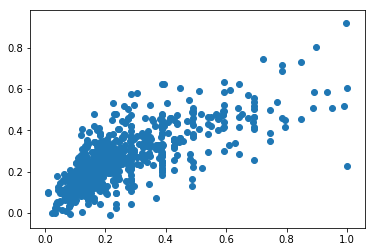

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)
plt.scatter(y_test,y_pred)

In [63]:
sklearn.metrics.mean_absolute_error(y_test,y_pred)

0.08300529728843936

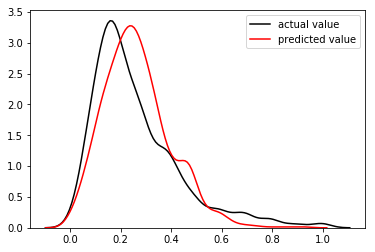

In [38]:
ax1=sn.distplot(y_test,hist=False,color='black',label='actual value')
ax2=sn.distplot(y_pred,hist=False,color='red',label='predicted value')

In [39]:
olsmod = sm.OLS(y_test,X_test)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     850.6
Date:                Sun, 28 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:34:25   Log-Likelihood:                 1101.9
No. Observations:                1540   AIC:                            -2182.
Df Residuals:                    1529   BIC:                            -2123.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
accommodates            0.1308    

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)

C:\Users\shant\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


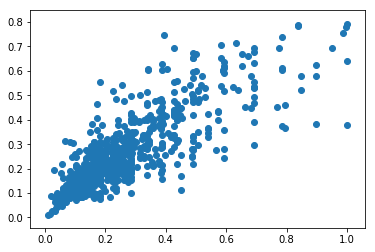

In [71]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
plt.scatter(y_test,y_pred)

In [72]:
sklearn.metrics.mean_absolute_error(y_test,y_pred)

0.06789115381217369

In [42]:
import statsmodels.api as sm
olsmod = sm.OLS(y_test,X_test)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     513.6
Date:                Sun, 28 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:41:42   Log-Likelihood:                 601.79
No. Observations:                 770   AIC:                            -1182.
Df Residuals:                     759   BIC:                            -1130.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
accommodates            0.1927    

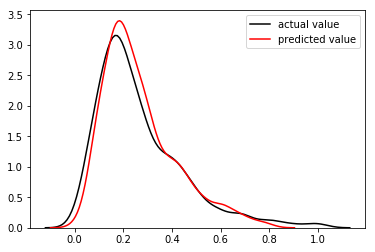

In [43]:
ax1=sn.distplot(y_test,hist=False,color='black',label='actual value')
ax2=sn.distplot(y_pred,hist=False,color='red',label='predicted value')

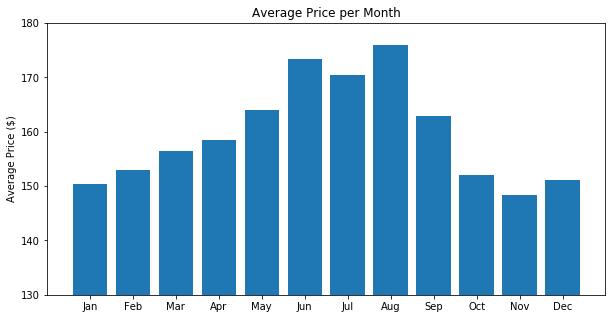

In [44]:
#price variations over the months
price = round(cal.groupby(['month']).mean()["price"],2)
#Plotting graph on price variations over the month
x_pos = np.arange(len(price))
plt.figure(figsize=(10,5))
plt.bar(x_pos,price,align='center')
#plt.plot(price['price'])
plt.ylabel('Average Price ($)')
axes = plt.gca()
axes.set_ylim([130,180])
plt.title('Average Price per Month')
plt.xticks(x_pos,months)
plt.show()

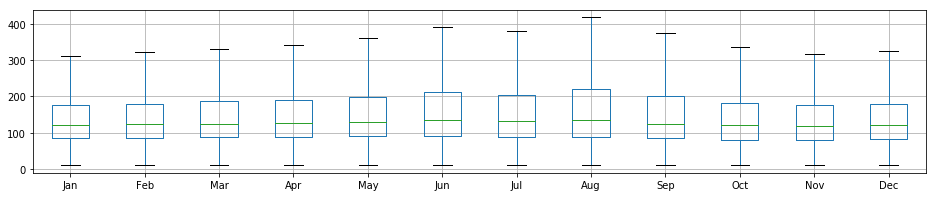

In [45]:
price_month=cal[['month','price']]
price_month_mean=price_month.groupby('month').mean()
price_month1=price_month.pivot(columns='month',values='price')
plt.figure(figsize=(16,3))
plot2=price_month1.boxplot(showfliers=0)

In [46]:
#Which neighbourhood has most listings
listings.groupby('neighbourhood_group_cleansed').mean()['price'].sort_values(ascending=False)

neighbourhood_group_cleansed
Downtown               182.403767
Queen Anne             165.221254
Cascade                160.978992
Magnolia               155.087248
Ballard                144.301471
West Seattle           144.130435
Capitol Hill           140.278409
Central Area           138.518828
Other neighborhoods    125.334457
Seward Park            124.197183
Beacon Hill            114.688742
Rainier Valley         112.984456
Interbay               105.722222
Lake City              101.111111
Delridge               100.256198
University District     97.941406
Northgate               92.106742
Name: price, dtype: float64

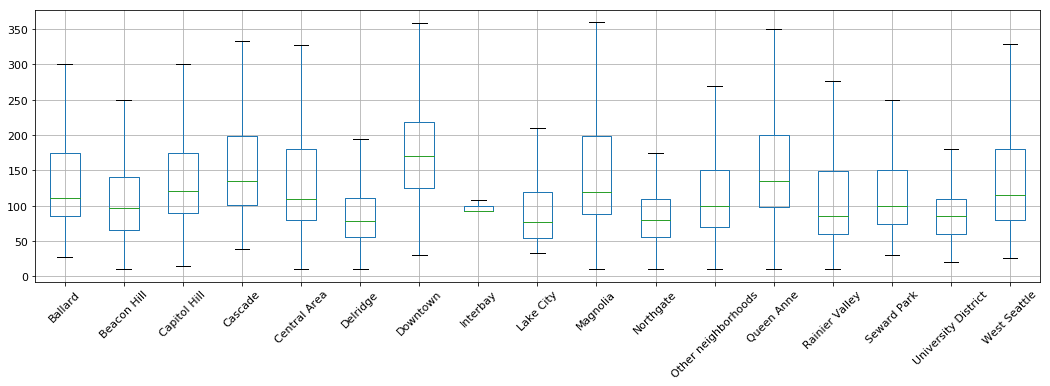

In [47]:
price_area=listings[['neighbourhood_group_cleansed','price']]
price_area_mean=price_area.groupby('neighbourhood_group_cleansed').mean()
price_area1=price_area.pivot(columns='neighbourhood_group_cleansed',values='price')
plt.figure(figsize=(18,5))
plot3=price_area1.boxplot(showfliers=False,rot=45,fontsize=11)

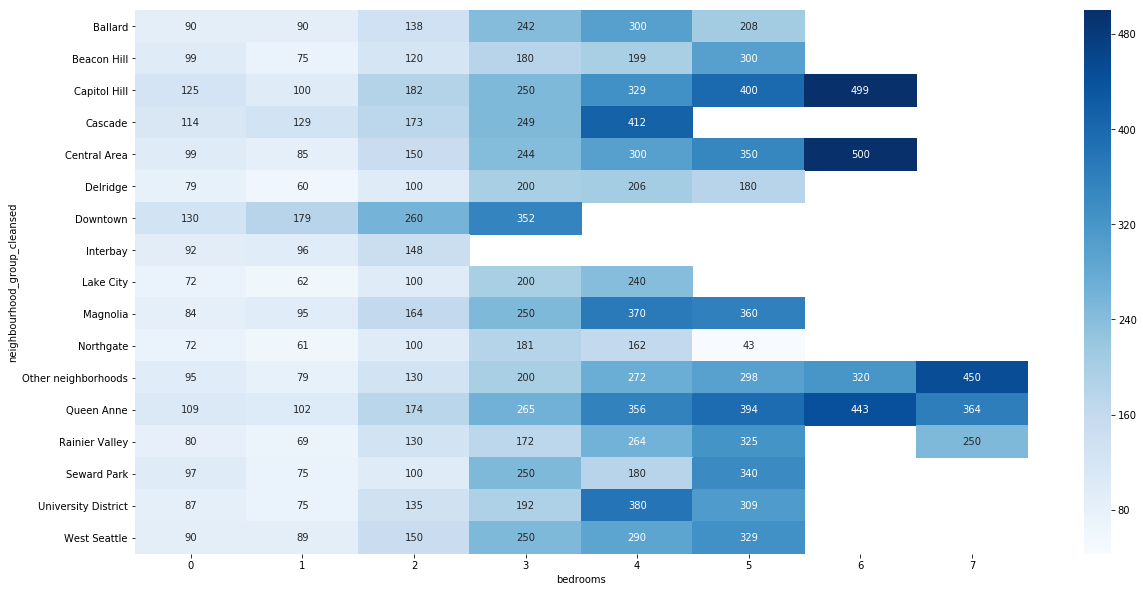

In [48]:
plt.figure(figsize=(20,10))
sn.heatmap(listings.groupby([
        'neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(),annot=True, fmt=".0f",cmap="Blues")

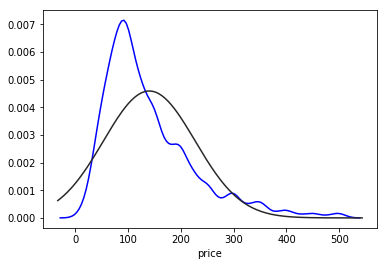

In [49]:
sn.distplot(listings['price'],hist=False,fit=norm,color="blue")

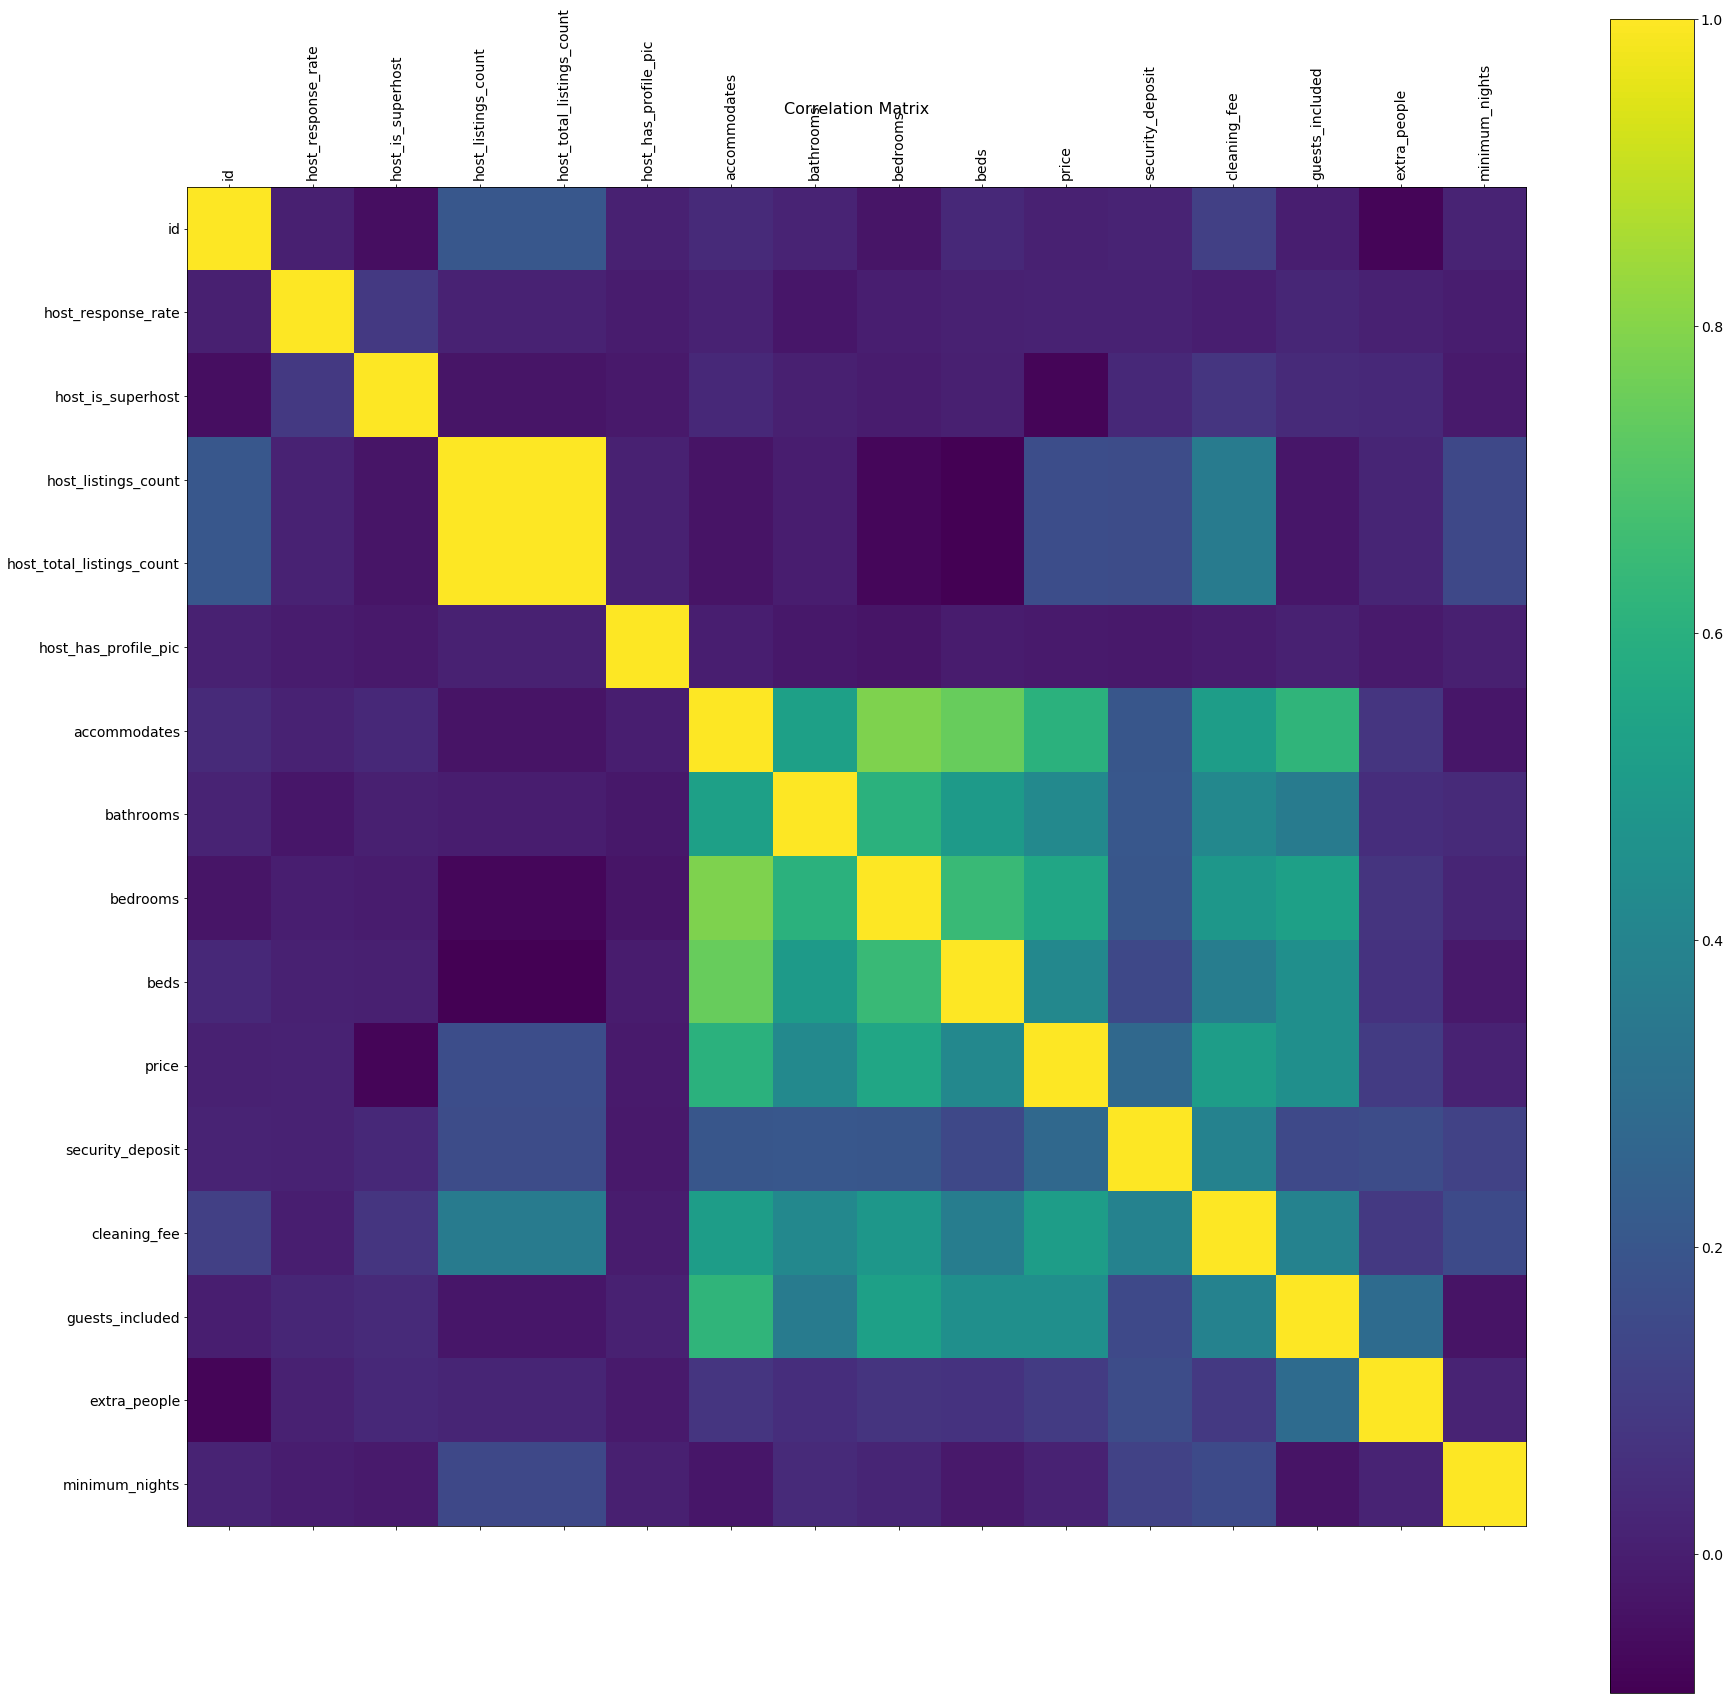

In [50]:
listings_feature_corr = listings_feature.loc[:,:'minimum_nights']

f=plt.figure(figsize=(30,30))
plt.matshow(listings_feature_corr.corr(),fignum=f.number)

plt.xticks(range(listings_feature_corr.shape[1]), listings_feature_corr.columns, fontsize=14, rotation=90)
plt.yticks(range(listings_feature_corr.shape[1]), listings_feature_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()
